# B2B analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.dsp        import lowPassFIR, firFilter, pulseShape, decimate, pnorm
from optic.metrics    import fastBERcalc, signal_power, theoryBER
from optic.modulation import modulateGray
from optic.core       import parameters
from optic.models     import awgn, photodiode
from optic.plot       import pconst

from utils.ofdm       import modulateOFDM, demodulateOFDM, Tx, Rx, calcSymbolRate
from commpy.utilities import upsample
from tqdm.notebook    import tqdm
from scipy.signal     import hilbert

pi = np.pi

In [2]:
import scienceplots

plt.style.use('science')
font = {'size':20}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

## 1 - Teste do OFDM convencional

In [18]:
# OFDM
M    = 16                       # Número de símbolos da constelação QAM
Nfft = 512                      # Tamanho da FFT
Ns = int(Nfft/2) - 1            # Número de sub-portadoras
N  = Ns                         # Número de portadoras de informação
Nz = Ns - N                     # Número de subportadoras nulas
G  = 4                          # Tamanho do prefixo cíclico
K  = 4                          # Número de portadoras piloto por bloco OFDM

Rb  = 3e9                       # Taxa de bits/s
Rs  = calcSymbolRate(M, Rb, Nfft, K, G, True)   # Taxa de símbolos
SpS = 16                        # Amostras por símbolo
Fa  = Rs*SpS                    # Frequência de amostragem
Fc  = 193.4e12                  # Frequência da portadora óptica

In [19]:
# Sequência aleatória de bits
bits = np.random.randint(2, size = ((Nfft-K-2)//2)*2**9)

# Mapeamento dos bits em símbolos
symbTx = modulateGray(bits, M, 'qam')
symbTx = pnorm(symbTx) # power normalization

# Escolha da portadora pilot
pilot = max(symbTx.real) + 1j*max(symbTx.imag)

# Geração de símbolos OFDM
symbTx_OFDM, symbTx = modulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbTx)

# Upsampling e formatação de pulso
pulse = pulseShape('rrc', SpS, alpha = 0.15)
pulse = pnorm(pulse)

sigOFDM_Tx = firFilter(pulse, upsample(symbTx_OFDM, SpS))
sigOFDM_Tx = pnorm(sigOFDM_Tx)

In [20]:
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1

In [13]:
SNR = np.arange(5, 25)
BER = np.zeros(SNR.shape)
BERth = np.zeros(SNR.shape)
SNRest = np.zeros(SNR.shape)

for kk, runSNR in enumerate(SNR):
    sigOFDM_Rx = awgn(sigOFDM_Tx, runSNR, Fa, Rs)
    sigOFDM_Rx = firFilter(pulse, sigOFDM_Rx)

    sigOFDM_Rx = decimate(sigOFDM_Rx.reshape(-1,1), paramDec)
    sigOFDM_Rx = np.squeeze(sigOFDM_Rx)
    
    # Demodulação dos símbolos OFDM
    symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, pnorm(sigOFDM_Rx))
    
    discard = 100
    ind = np.arange(discard,len(symbRx_neq)-discard)
    BER[kk], _, SNRest[kk] = fastBERcalc(symbRx_neq[ind], symbTx[ind], M, 'qam')
    EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
    BERth[kk] = theoryBER(M, EbN0, 'qam')

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


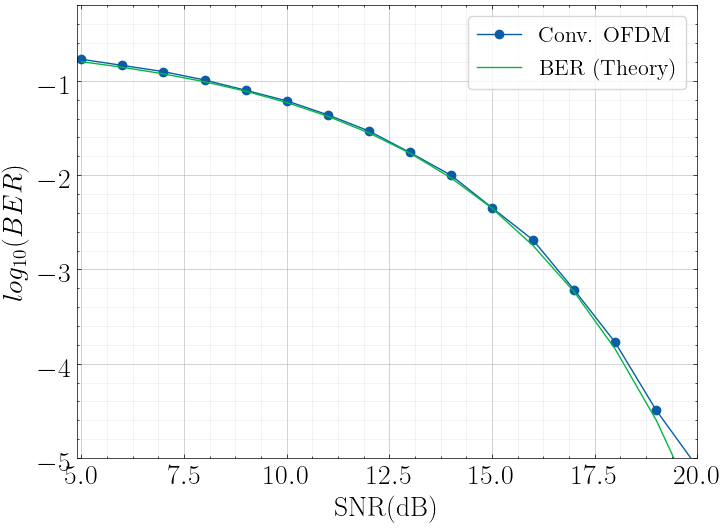

In [14]:
plt.figure(figsize = (8, 6))

plt.plot(SNR, np.log10(BER),'-o', ms= 6, label = f'Conv. OFDM')
plt.plot(SNR, np.log10(BERth),'-', label = 'BER (Theory)')

plt.ylim(-5)
plt.xlim(4.9, 20)
plt.xlabel('SNR(dB)', fontsize = 20)
plt.ylabel('$log_{10}(BER)$', fontsize = 20)
plt.legend(fontsize = 16,frameon = True)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.8)

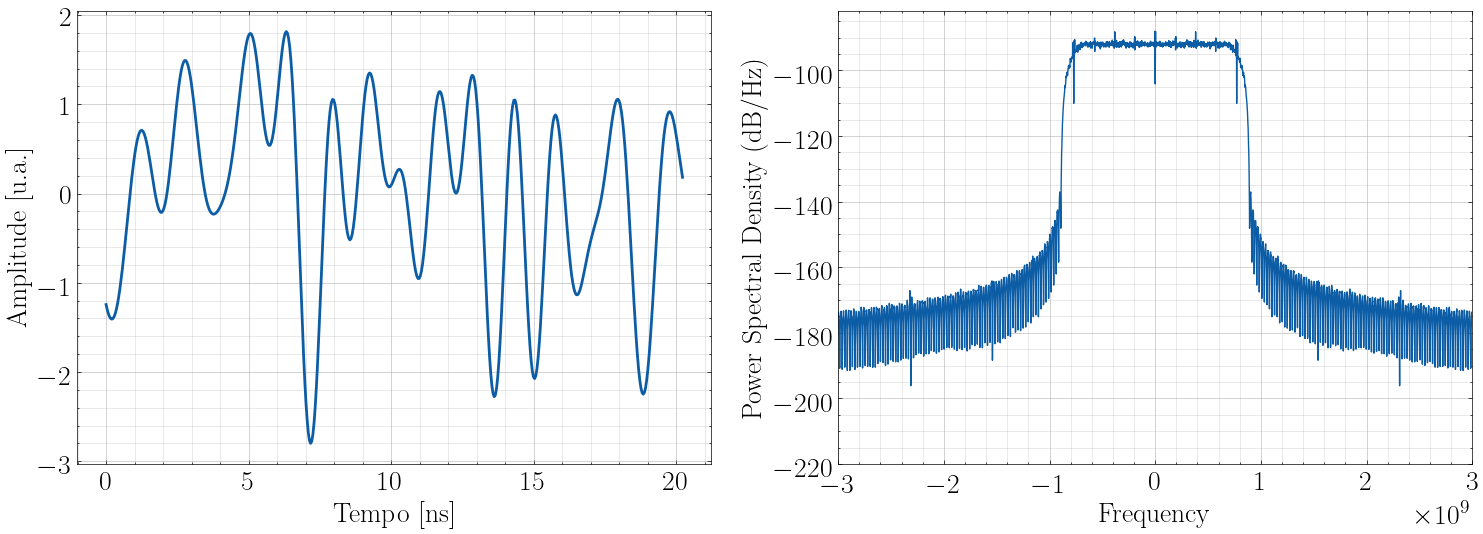

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
idX = np.arange(0, 500)

t = np.arange(0, len(sigOFDM_Tx))*(1/Fa)

ax[0].plot(t[idX]*1e9, (sigOFDM_Tx)[idX].real, lw = 2)
ax[0].set_xlabel('Tempo [ns]')
ax[0].set_ylabel('Amplitude [u.a.]')
ax[0].grid(which='minor', alpha=0.4)
ax[0].grid(which='major', alpha=0.8)

ax[1].psd(sigOFDM_Tx, Fs = Fa, NFFT = 16*1024, sides='twosided')
ax[1].set_xlim(-3e9, 3e9)
ax[1].grid(which='minor', alpha=0.4)
ax[1].grid(which='major', alpha=0.8)

## 2 - CE-OFDM

  0%|          | 0/5 [00:00<?, ?it/s]

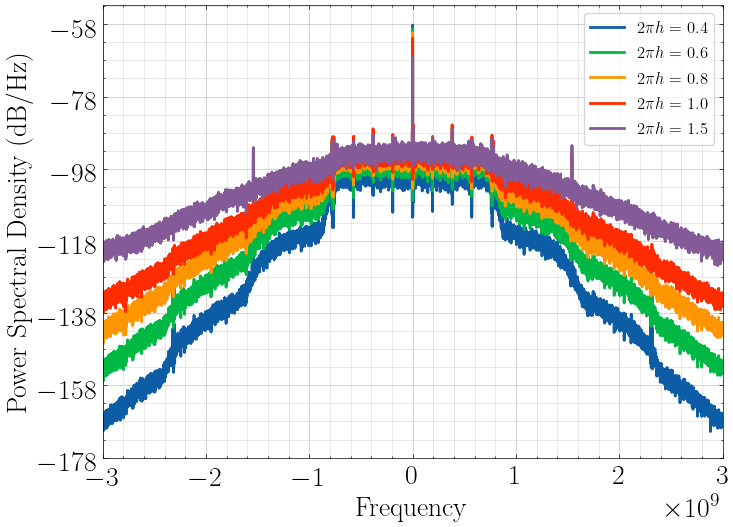

In [21]:
h = np.array([0.4, 0.6, 0.8, 1, 1.5])/(2*pi)

SNR = np.arange(5, 30)
BER = np.zeros((len(h), len(SNR)))
BERth = np.zeros(SNR.shape)
SNRest = np.zeros((len(h), len(SNR)))

fig, ax = plt.subplots(figsize = (8, 6))

for i in tqdm(range(len(h))):
    # CE-OFDM
    H = h[i]
    A = 1
    sigCEOFDM_Tx = A*np.exp(1j*2*pi*H*sigOFDM_Tx)
    
    ax.psd(sigCEOFDM_Tx, Fs = Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"$2\pi h =$ {round(2*pi*h[i],2)}")
    ax.legend(frameon = True)
    ax.set_xlim(-3e9, 3e9)
    ax.legend(frameon = True, fontsize = 12)
    
    for kk, runSNR in enumerate(SNR):
        sigOFDM_Rx = awgn(sigCEOFDM_Tx, runSNR, Fa, max(2*pi*H*Rs,Rs))

        phase = np.unwrap(np.arctan2(sigOFDM_Rx.imag, sigOFDM_Rx.real))  #/(2*pi*H)
        phase = pnorm(firFilter(pulse, phase))

        symbRx_OFDM = decimate(phase.reshape(-1,1), paramDec)
        symbRx_OFDM = pnorm(np.squeeze(symbRx_OFDM))
        
        # Demodulação dos símbolos OFDM
        symbRx, symbRx_neq, H_abs, H_pha = demodulateOFDM(Nfft, Ns, N, Nz, G, K, pilot, symbRx_OFDM)

        discard = 100
        ind = np.arange(discard,len(symbRx)-discard)
        BER[i, kk], _, SNRest[i, kk] = fastBERcalc(symbRx_neq[ind], symbTx[ind], M, 'qam')
        EbN0 = SNR[kk] - 10*np.log10(np.log2(M))
        BERth[kk] = theoryBER(M, EbN0, 'qam')
           
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


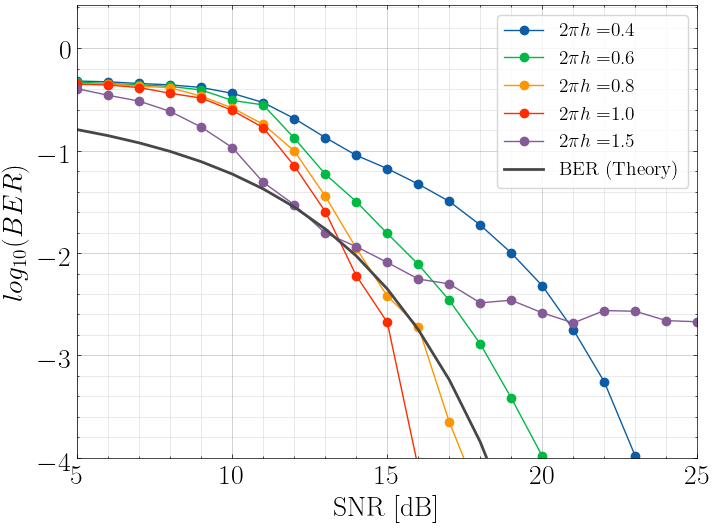

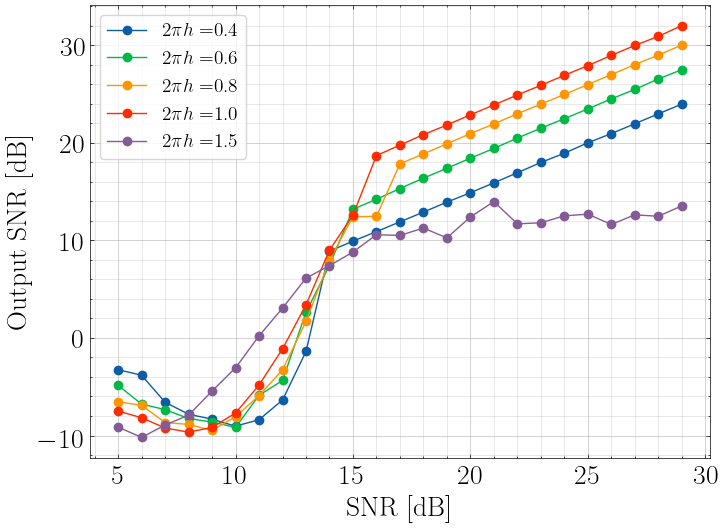

In [31]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(SNR, np.log10(BER[i,:]),'-o', ms= 6, label = f'$2\pi h = ${round(2*pi*h[i], 2)}')

plt.plot(SNR, np.log10(BERth),lw = 2, ls = '-', label = 'BER (Theory)')

plt.ylim(-4)
plt.xlim(5, 25)
plt.xlabel('SNR [dB]')
plt.ylabel('$log_{10}(BER)$')
plt.legend(fontsize = 14,frameon = True)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(SNR, SNRest[i, :],'-o', ms= 6, label = f'$2\pi h = ${round(2*pi*h[i], 2)}')

plt.xlabel('SNR [dB]')
plt.ylabel('Output SNR [dB]')
plt.legend(fontsize = 14,frameon = True)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

## 3 - CE-DDO-OFDM e DDO-OFDM

In [24]:
paramTx = parameters()

# Parâmetros do esquema OFDM
paramTx.M    = 16                       # Número de símbolos da constelação QAM
paramTx.Nfft = 512                      # Tamanho da FFT
paramTx.Ns = int(paramTx.Nfft/2) - 1    # Número de sub-portadoras
paramTx.N  = paramTx.Ns                 # Número de portadoras de informação
paramTx.Nz = paramTx.Ns - paramTx.N     # Número de subportadoras nulas
paramTx.G  = 4                          # Tamanho do prefixo cíclico
paramTx.K  = 4                          # Número de portadoras piloto por bloco OFDM

# Parâmetros da transmissão
Rb = 3e9                                # Taxa de bits/s
paramTx.Rs  = calcSymbolRate(paramTx.M, Rb, paramTx.Nfft, paramTx.K, paramTx.G, True)
paramTx.SpS = 16                        # Amostras por símbolo
paramTx.Fa  = paramTx.Rs*paramTx.SpS    # Frequência de amostragem

# Parâmetros da portadora elétrica
paramTx.H  = 0.45/(2*pi)                # Parâmetro de modulação
paramTx.A  = 1.15                       # Amplitude
paramTx.fc = 1e9                        # Frequência da portadora [Hz]

# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Pi_dBm = 2
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.g = 0.45

# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 2.5e9       # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True     # Definição do modelo: ideal ou real

# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica

paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [25]:
filtro_optico_Tx = lowPassFIR(4e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_DD = lowPassFIR(1.9e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_CEDD = lowPassFIR(2.9e9, paramTx.Fa, 8001, typeF='rect')

## 3.1 - Influência da OSNR no desempenho

In [26]:
OSNR = np.arange(5, 25, 1)
h = np.array([0.25, 0.35, 0.45, 0.55])/(2*pi)

BER_CEDD_B2B = np.zeros((len(h), len(OSNR)))
BER_DD_B2B = np.zeros(OSNR.shape)

SNR_CEDD_B2B = np.zeros((len(h), len(OSNR)))
SNR_DD_B2B = np.zeros(OSNR.shape)

In [ ]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
paramTx.A  = 1.15

fig, ax = plt.subplots(1, 2, figsize = (18, 6))

for i in tqdm(range(len(h))):
    paramTx.H = h[i]
    paramRx.H = paramTx.H
    
    for ind, osnr in enumerate(OSNR):
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        if(ind == 0):
            ax[0].psd(sigTx_CE, Fs = paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"CE-DDO - $2\pi h =$ {round(2*pi*h[i],2)}")
            ax[0].legend(fontsize = 14, frameon = True)
            ax[0].set_xlim(-4e9, 4e9)
            
            ax[1].psd(sigTxo, Fs = paramTx.Fa, NFFT = 16*1024, sides='twosided', lw = 2, label = f"CE-DDO - $2\pi h =$ {round(2*pi*h[i],2)}")
            ax[1].legend(fontsize = 14, frameon = True)
            ax[1].set_xlim(-4e9, 4e9)

        # Canal AWGN
        snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)

        # Recepção óptica
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_CEDD_B2B[i, ind], _, SNR_CEDD_B2B[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam') 

  0%|          | 0/4 [00:00<?, ?it/s]

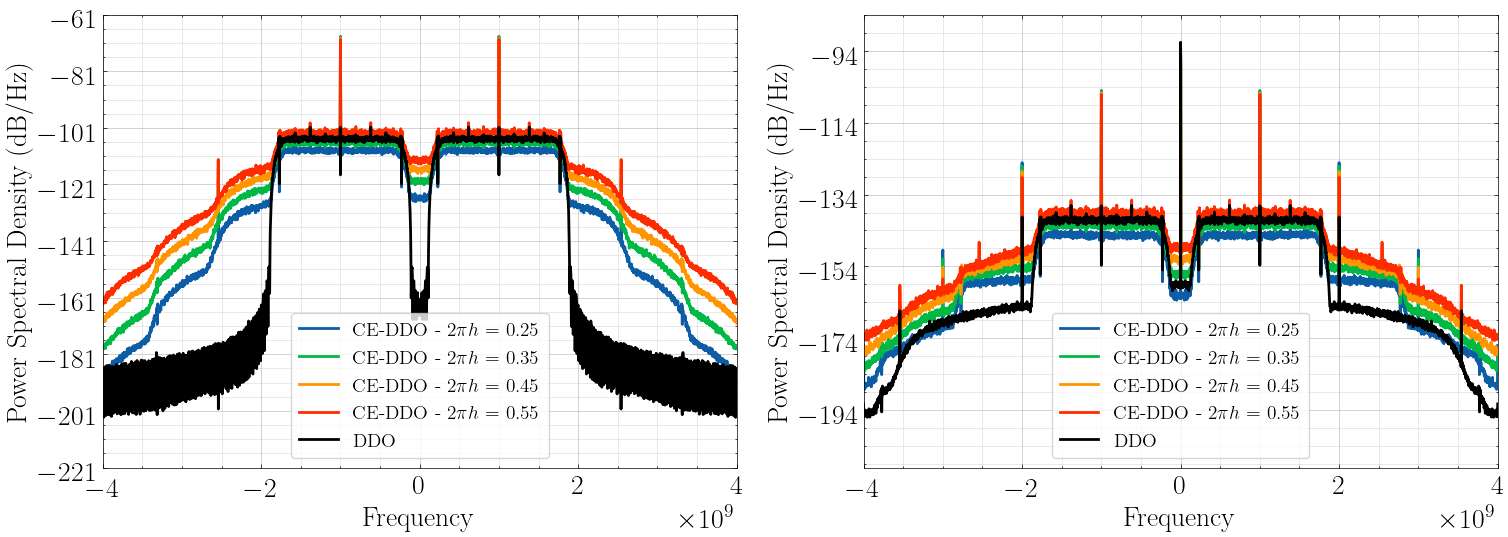

In [27]:
paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme
paramTx.g = 0.45

for ind, osnr in enumerate(OSNR):   
    # Geração do sinal óptico
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    if(ind == 0):
        ax[0].psd(sigTx_DD, Fs = paramTx.Fa, NFFT = 16*1024, color = 'k', sides='twosided', lw = 2, label = "DDO")
        ax[0].set_xlim(-4e9, 4e9)
        ax[0].legend(frameon = True, fontsize = 14)
            
        ax[1].psd(sigTxo, Fs = paramTx.Fa, NFFT = 16*1024, color = 'k', sides='twosided', lw = 2, label = "DDO")
        ax[1].set_xlim(-4e9, 4e9)
        ax[1].legend(frameon = True, fontsize = 14)
    
    snr = osnr - 10*np.log10(paramPD.B/(2*12.5e9))
    sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
    # Recepção óptica
    sigRxo = firFilter(filtro_optico_DD, sigRxo)
    ipd = photodiode(sigRxo, paramPD)
    
    # Demodulação dos símbolos
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)  
    
    BER_DD_B2B[ind], _, SNR_DD_B2B[ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam') 

ax[1].set_ylim(-210)
ax[0].grid(which='minor', alpha=0.4)
ax[0].grid(which='major', alpha=0.8)
ax[1].grid(which='minor', alpha=0.4)
ax[1].grid(which='major', alpha=0.8)

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


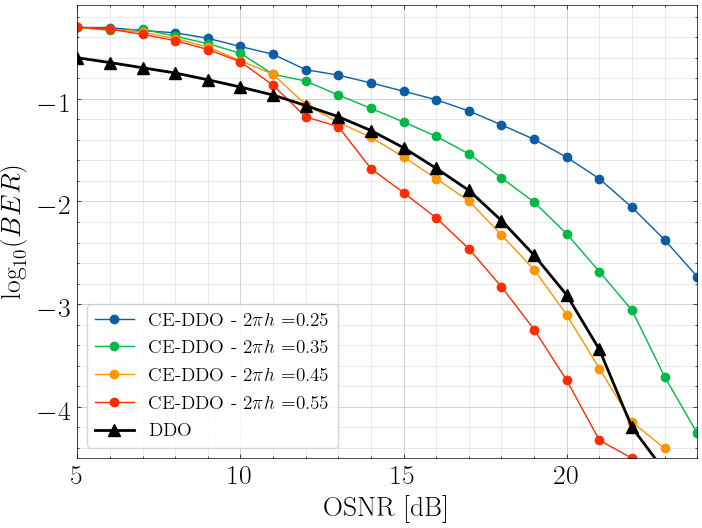

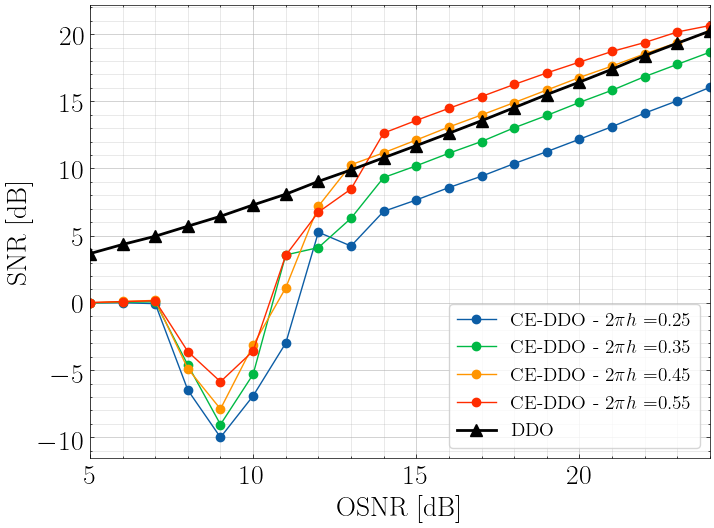

In [28]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OSNR, np.log10(BER_CEDD_B2B[i,:]),'-o', ms= 6, label = f'CE-DDO - $2\pi h = ${round(2*pi*h[i], 2)}')

plt.plot(OSNR, np.log10(BER_DD_B2B), 'k-^', ms = 8, lw = 2, label = f'DDO')

plt.ylim(-4.5)
plt.xlim(min(OSNR), max(OSNR))
plt.xlabel('OSNR [dB]')
plt.ylabel(r'$\log_{10}(BER)$')
plt.legend(fontsize = 14,frameon = True)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OSNR, SNR_CEDD_B2B[i,:],'-o', ms= 6, label = f'CE-DDO - $2\pi h = ${round(2*pi*h[i], 2)}')

plt.plot(OSNR, SNR_DD_B2B, 'k-^', ms = 8, lw = 2, label = f'DDO')

plt.xlabel(r"OSNR [dB]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True, loc = 'lower right')
plt.xlim(min(OSNR), max(OSNR))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

## 3.2 - Polarização do MZM sob um canal AWGN

### 3.2.1 - BER, SNR vs OMI, h - CE-DDO-OFDM

In [107]:
OMI = np.arange(0.05, 0.55, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
h  = np.array([0.25, 0.35, 0.45, 0.55])/(2*pi)

paramTx.Vb = -0.5*paramTx.Vπ

OSNR = 20
BER_CEDD_OMI = np.zeros((len(h), len(A)))
SNR_CEDD_OMI = np.zeros((len(h), len(A)))

In [109]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(h))):
    paramTx.H = h[i]
    paramRx.H = paramTx.H
    
    for ind, AA in enumerate(A):   
        paramTx.A = AA
        
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        # Canal AWGN
        snr = OSNR - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)
        
        # Recepção óptica
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CEDD_OMI[i, ind], _, SNR_CEDD_OMI[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')     

  0%|          | 0/4 [00:00<?, ?it/s]

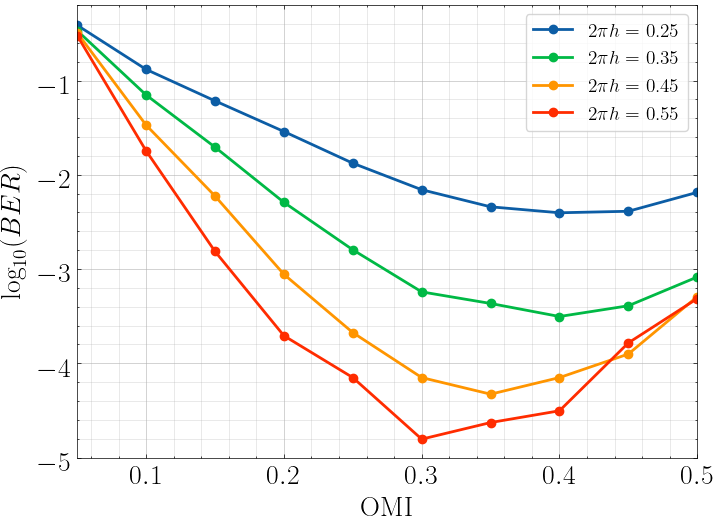

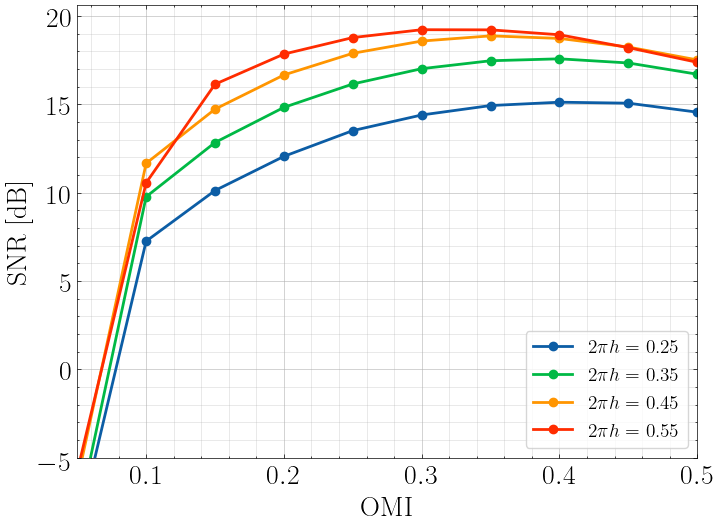

In [99]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, np.log10(BER_CEDD_OMI[i,:]), '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, SNR_CEDD_OMI[i,:], '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

### 3.2.2 - BER, SNR vs OMI, Vb - CE-DDO-OFDM

In [ ]:
OMI = np.arange(0.05, 0.55, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

IL = np.zeros((len(Vb), len(A)))

paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H

BER_CEDD_Vb = np.zeros((len(Vb), len(A)))
SNR_CEDD_Vb = np.zeros((len(Vb), len(A)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [100]:
for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, AA in enumerate(A):
        paramTx.A = AA
        
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        IL[i, ind] = 10*np.log10(1000*signal_power(sigTxo)) - paramTx.Pi_dBm
        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        # Canal AWGN
        snr = OSNR - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)

        # Recepção óptica
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_CEDD_Vb[i, ind], _, SNR_CEDD_Vb[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')       

  0%|          | 0/3 [00:00<?, ?it/s]

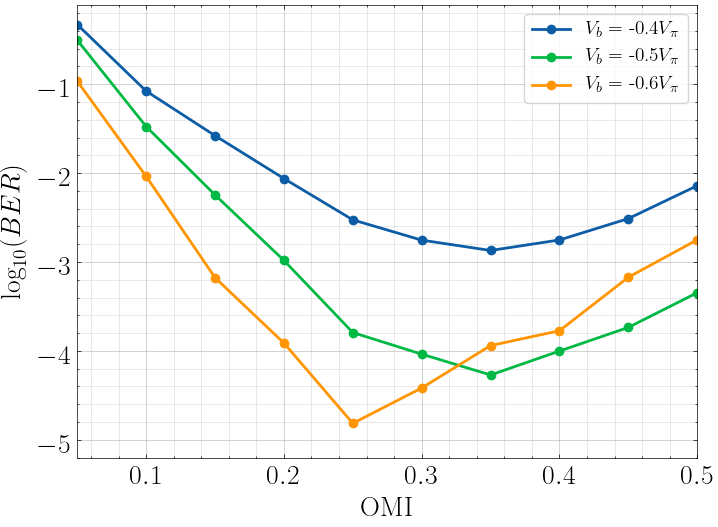

<Figure size 900x400 with 0 Axes>

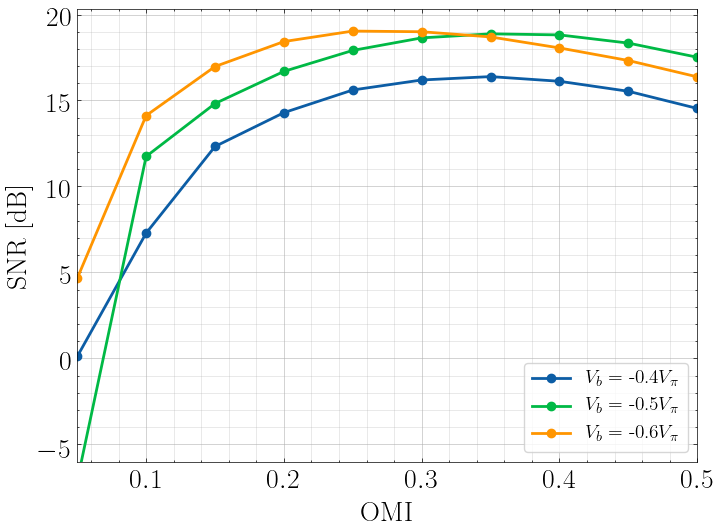

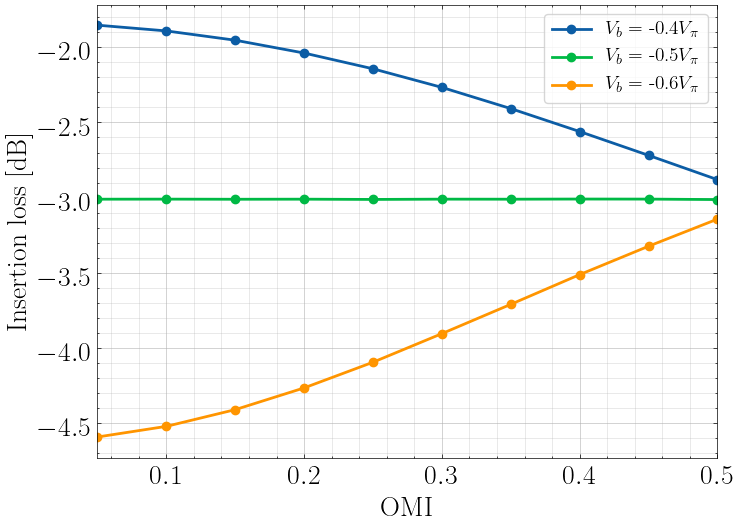

In [101]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_CEDD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5.2)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_CEDD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(-6)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# Insertion Loss vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, IL[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"Insertion loss [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

### 3.2.3 - BER, SNR vs OMI, Vb - DDO-OFDM

In [ ]:
g = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

OMI = np.zeros(len(g))
IL = np.zeros((len(Vb), len(g)))

BER_DD_OMI = np.zeros((len(Vb), len(g)))
SNR_DD_OMI = np.zeros((len(Vb), len(g)))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [102]:
for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, gg in enumerate(g):
        paramTx.g = gg
        
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
        
        if(i == 0):
            OMI[ind] = np.sqrt(np.mean((sigTx_DD)**2))/paramTx.Vπ
        
        IL[i, ind] = 10*np.log10(1000*signal_power(sigTxo)) - paramTx.Pi_dBm
        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        # Canal AWGN
        snr = OSNR - 10*np.log10(paramPD.B/(2*12.5e9))        
        sigRxo = awgn(sigTxo, snr, paramTx.Fa, paramPD.B)

        # Recepção óptica
        sigRxo = firFilter(filtro_optico_DD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        BER_DD_OMI[i, ind], _, SNR_DD_OMI[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')    

  0%|          | 0/3 [00:00<?, ?it/s]

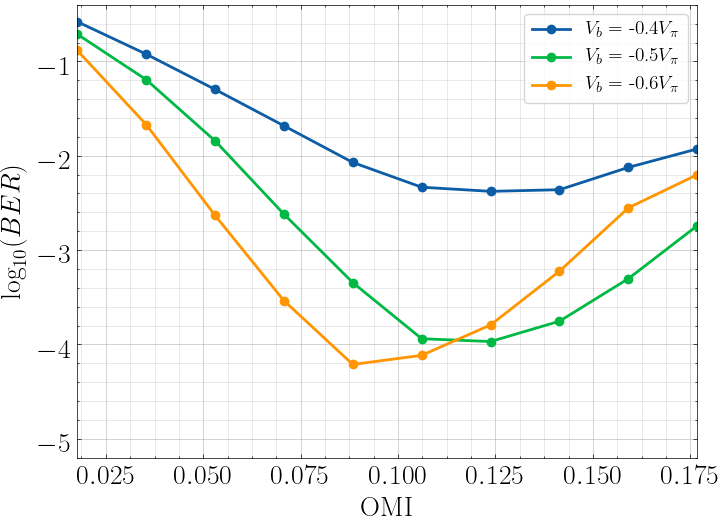

<Figure size 900x400 with 0 Axes>

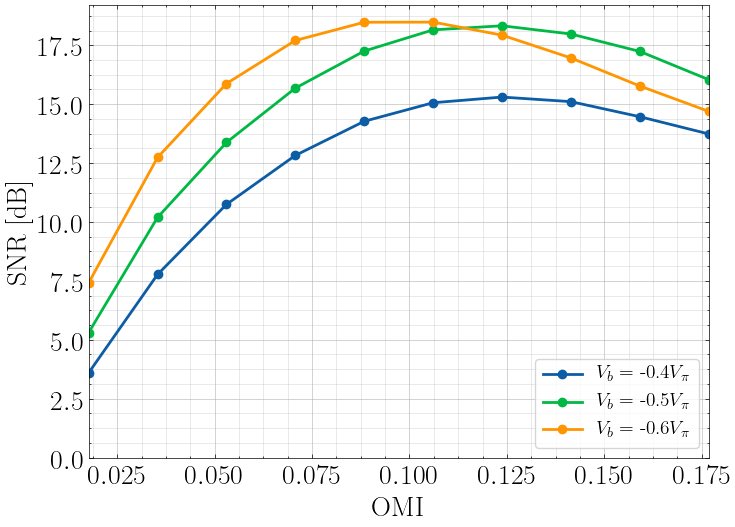

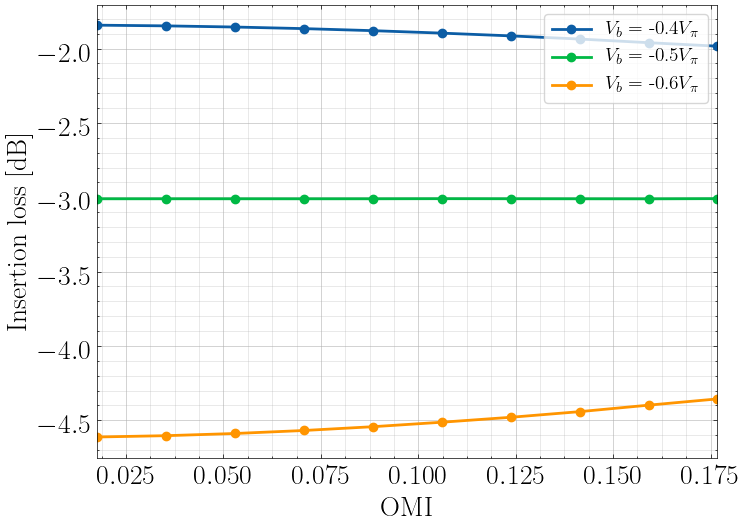

In [103]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_DD_OMI[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5.2)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_DD_OMI[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# Insertion Loss vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, IL[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"Insertion loss [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)